# Land-Cover Classification with EuroSAT Dataset


![](https://raw.githubusercontent.com/phelber/EuroSAT/master/eurosat_overview_small.jpg) 



In this notebook we will tackle the problem of land-use and land-cover classification where we try to identify the class of given remote sensing image based on some well defined target class labels. For training the model we will use the EuroSAT dataset from this [paper](https://arxiv.org/abs/1709.00029) published in 2019 which is now a standard benchmark for land-cover classification task. 

This dataset consisits of 64x64 images captured by Sentinel-2A satellite and it has over **27000 images** spread across **10 classes**. Originally the data consists of hyperspectral images with 13 spectral bands but we will be working with only RGB channels downloaded from [here](http://madm.dfki.de/files/sentinel/EuroSAT.zip). 

The paper states that the finetuned CNN model **ResNet50** performed best with 80-20 split on the data for RGB channels giving about **98.57%** accuracy. 

Finally, this notebook was forked and edited from [here](https://www.kaggle.com/silentj23/eurosat-image-classification#II.-Preprocessing).

**NOTE:** This notebook is still a work in progress so expect a final version soon

In [2]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

# I. Data Exploration

In this project, I'll be exploring the EUROSAT dataset. The EUROSAT dataset is composed of images taken from the Sentinel-2 satellite. This dataset lists images of the earth's surface into 10 different land cover labels. For this project, I will build an image classification model for predicting a land cover label, given an image. 

**loading the dataset that contains images in jpeg format. Sizes of images:64*64*3. The main dataset has sub datasets that denote the category of image. Those categories are listed here.**

In [3]:
DATASET = "../input/eurosat-rgb/2750"

LABELS = os.listdir(DATASET)
print(LABELS)

['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'AnnualCrop', 'Forest', 'HerbaceousVegetation']


**This snippet is used to show the number of images in each class**

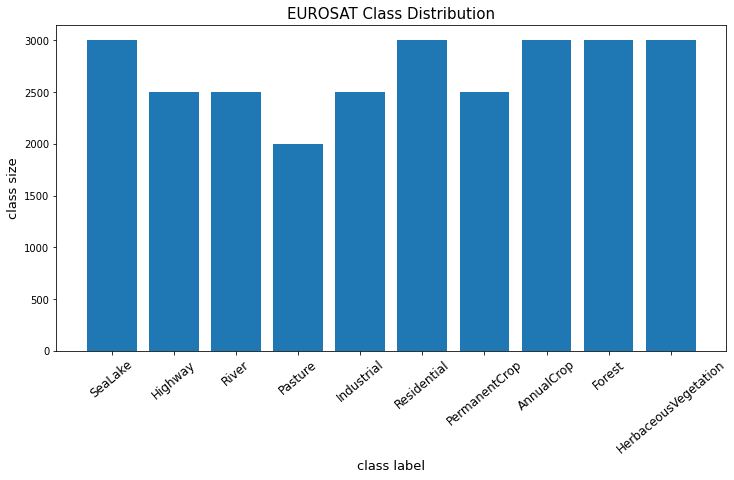

In [4]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

The dataset is split into 10 classes of land cover. Each class varies in size, so I'll have to stratify later on when splitting the data into training, testing and validation sets. 

**visualisation of data**

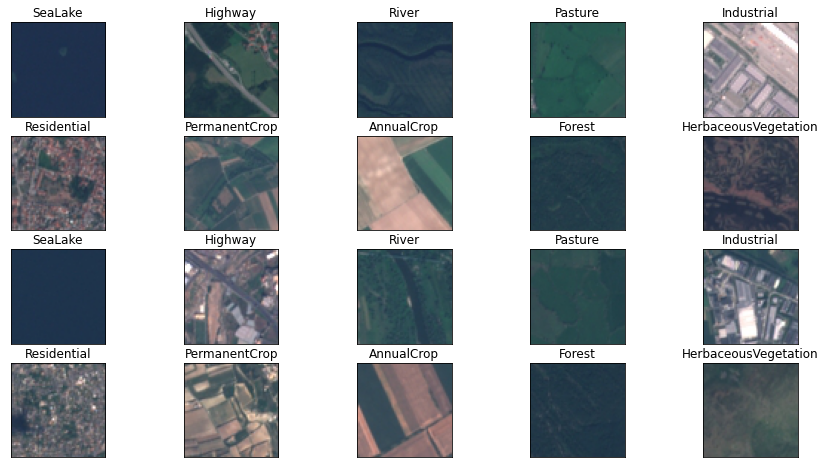

In [5]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

Looking at the preview of the different classes, we can see some similarities and stark differences between the classes. 

Urban environments such as Highway, Residential and Industrial images all contain structures and some roadways. 

AnnualCrops and PermanentCrops both feature agricultural land cover, with straight lines dilineating different crop fields. 

Finally, HerbaceaousVegetation, Pasture, and Forests feature natural land cover; Rivers also could be categorized as natural land cover as well, but may be easier to distinguish from the other natural classes.

If we consider the content of each image, we might be able to estimate which classes might be confused for each other. For example, an image of a river might be mistaken for a highway. Or an image of a highway junction, with surrounding buildings, could be mistaken for an Industrial site. We'll have to train a classifier powerful enough to differentiate these nuances. 

Sentinel-2 satellite images could also be downloaded with 10+ additional bands. Near-Infrared Radiation bands, for example, is a band of data that is available for this dataset. NIR can be used to create an index, visualising the radiation that is present (or not present) in a picture. This dataset does not contain the NIR wavelength bands, so this option will not be explored. But it's worth pointing out that this classification task could be addressed in another way using NIR data. 

# II. Preprocessing

I'd like to evaluate the performance of the model later on after training, so I'll perform a stratified shuffle-split using Scikit-learn to maintain class proportions. 30% of the dataset will be held for evaluation purposes. I'll be loading my data into the Keras model using the ImageDataGenerator class. I'll need the images to be in their own respective land cover directories. 

After splitting the dataset, I'll create some image augmentations using the generator and also denote a subset of the training data to be used as validation data during training. 

**creating two sub-directories inside kaggle/working and sub-directories inside them denoting the various classes.**

In [6]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '../working/training'
TEST_DIR = '../working/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

**Data is a dictionary where the keys are image paths and the labels are their classes. y is used to one-hot encode the labels in data. Then train test split is carried out and image files are shifted to training and testing directories under /kaggle/working**

In [7]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('\.\.\/input\/eurosat-rgb\/2750', '../working/training', i) for i in train_paths]
    new_test_paths = [re.sub('\.\.\/input\/eurosat-rgb\/2750', '../working/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

  0%|          | 0/5400 [00:00<?, ?it/s]

moving training files..
moving testing files..


100%|██████████| 5400/5400 [00:00<00:00, 105212.69it/s]


**these are used to resize images, specify the batches in which they'll be trained, specify that there is one-hot encoding, and shuffle the images.**

In [8]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


**printing the one-hot encoding of classes.**

In [9]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [10]:
print(test_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [11]:
np.save('class_indices', train_generator.class_indices)

# IV. Deep Learning For Image Classification

Deep Learning has highly influenced the field of computer vision when Convolutional Neural Networks (CNN) models were used in tasks like image classification, object detection, facial recognition etc. As discussed by authors of EuroSAT paper many deep learning models outperform the traditional non deep learning methods by a large margin. 

In this section we will train many state of the art architectures which performed well on the ILSVRC challenge. The authors achieved an accuracy of 98.57% using a fine tuned ResNet50 model. Here, I will try to employ a similar strategy for training the models where initially the CNN part of the model will be frozen with imagenet weights and dense layers will be trained with a high learning rate of 0.01 and later we will train the whole model end-to-end i.e. fine tune by keeping a small learning rate between 0.001 to 0.0001

Before we start here is a list of CNN models which we will train:
1. ResNet50
2. ResNet50V2
3. ResNet152V2
3. VGG16
4. VGG19

In future
5. InceptionV3
6. Xception

In [5]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from keras.applications import VGG16, VGG19
from keras.applications import ResNet50, ResNet50V2, ResNet152V2
from keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [14]:
# Note that for different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
       
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

In [16]:
compile_model.summary()

AttributeError: 'function' object has no attribute 'summary'

In [ ]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

## 4.1 ResNet50 Model

**CONSTRUCTION OF THE LAYERS**

In [ ]:
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet50_model.summary()

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

**Train the cnn on the data created by tarin generator and test it on the data created by test generator**

In [ ]:
# First Pretraining the dense layer
resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=10,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

In [ ]:
# re-train whole network end2end 
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=10,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

In [ ]:
plot_history(resnet50_history)

In [ ]:
resnet50_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

In [ ]:
# Save the model and the weights
resnet50_model.save('../working/ResNet50_eurosat.h5') 

In [3]:
from keras.models import load_model

# Load the model
model = load_model('/kaggle/working/ResNet50_eurosat.h5')

In [ ]:
import os
import pandas as pd
import numpy as np
from keras.applications.resnet50 import preprocess_input
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory where the test images are located
test_image_dir1 = '/kaggle/input/finaltest2'

# Initialize lists to store image paths, image names, predicted classes, and feature vectors
image_paths = []
image_names = []
predicted_classes = []
feature_vectors = []

# Load your pre-trained model
model = load_model('/kaggle/working/ResNet50_eurosat.h5')

# Remove the output layer to access the second last layer
second_last_layer = model.layers[-2]
feature_extraction_model = Model(inputs=model.input, outputs=second_last_layer.output)

# Create a generator for test images
test_gen1 = ImageDataGenerator(
    rescale=1./255  # Assuming your model expects input images in this format
)

test_generator1 = test_gen1.flow_from_directory(
    directory=test_image_dir1,
    target_size=(64, 64),
    batch_size=1,  # Set batch size to 1 for making predictions on individual images
    class_mode=None,  # No class labels for prediction
    color_mode='rgb',
    shuffle=False  # No need to shuffle for prediction
)

# Make predictions and extract feature vectors for each test image using the loaded model
for i in range(len(test_generator1.filenames)):
    img = test_generator1[i]  # Get the next batch of test data
    predictions = model.predict(img)
    predicted_class = predictions.argmax()  # Get the class with the highest probability
    features = feature_extraction_model.predict(img)  # Extract features from the second last layer
    
    # Append data to lists
    image_paths.append(test_generator1.filepaths[i])
    image_names.append(test_generator1.filenames[i])
    predicted_classes.append(predicted_class)
    feature_vectors.append(features)

# Convert the feature vectors list to a NumPy array
feature_vectors = np.vstack(feature_vectors)

# Create a pandas DataFrame
df = pd.DataFrame({'Image_Path': image_paths, 'Image_Name': image_names, 'Predicted_Class': predicted_classes})

# Add feature vector columns to the DataFrame
for i in range(feature_vectors.shape[1]):
    df[f'Feature_{i}'] = feature_vectors[:, i]

# Save the DataFrame to a CSV file
df.to_csv('/kaggle/working/predicted_results_with_features1.csv', index=False)



Found 819 images belonging to 1 classes.


In [ ]:
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# Define the directory where the images are located
image_dir = '/kaggle/input/finaltest2'

# Load the CSV file containing image information (including predicted classes)
df = pd.read_csv('/kaggle/working/predicted_results_with_features1.csv')

# Get a random sample of 20 images to display
sample_size = 25
random_indices = random.sample(range(len(df)), sample_size)

# Create a grid of subplots for the images
num_rows = 5  # Adjust the number of rows and columns as needed
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Iterate through the random indices and display images with predicted classes
for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    
    image_path = df.loc[idx, 'Image_Path']
    image_class = df.loc[idx, 'Predicted_Class']
    
    # Load and display the image
    img = Image.open(image_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Predicted Class: {image_class}')
    axes[row, col].axis('off')

# Hide any remaining empty subplots
for i in range(sample_size, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


In [1]:
#class_indices = train_generator.class_indices

# Reverse the mapping to create a dictionary that maps indices to labels
#class_labels = {v: k for k, v in class_indices.items()}

# Get the predicted class indices from your prediction generator
predicted_class_indices = test_generator1.classes

# Convert the predicted class indices to class labels
predicted_class_labels = [class_labels[i] for i in predicted_class_indices]
#print(class_labels)
print(predicted_class_labels)

NameError: name 'test_generator1' is not defined

In [ ]:
import os
import pandas as pd

# Define the directory where the images are located
image_dir = '/kaggle/input/finaltest1'

# Load the CSV file containing image information (including predicted classes)
df = pd.read_csv('/kaggle/working/predicted_results.csv')

# Create a list to store all predicted classes
all_predicted_classes = []

# Iterate through the DataFrame and collect the predicted classes
for idx, row in df.iterrows():
    image_path = row['Image_Path']
    image_class = row['Predicted_Class']
    all_predicted_classes.append((image_path, image_class))

# Print the list of all predicted classes with additional formatting
for i, (image_path, image_class) in enumerate(all_predicted_classes, start=1):
    print(f"Image {i}:")
    print(f"Image Path: {image_path}")
    print(f"Predicted Class: {image_class}")
    print("\n")  # Add a newline for separation

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# Define the directory where the images are located
image_dir = '/kaggle/input/finaltest1'

# Load the CSV file containing image information (including predicted classes)
df = pd.read_csv('/kaggle/working/predicted_results.csv')

# Get a random sample of images to display (you can change the sample size)
sample_size = 5
random_indices = random.sample(range(len(df)), sample_size)

# Create a subplot for each image
fig, axes = plt.subplots(1, sample_size, figsize=(15, 5))

# Iterate through the random indices and display images with predicted classes
for i, idx in enumerate(random_indices):
    image_path = df.loc[idx, 'Image_Path']
    image_class = df.loc[idx, 'Predicted_Class']
    
    # Load and display the image
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(f'Predicted Class: {image_class}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
